# Way Home

In [102]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

## Set Simulation Params and Create Grid

In [119]:
drunk_velocity = 1 # in m/s 
#car_velocitiy = 10 
car_intensitiy = 0.05 # probability that a car occurs on a lane 

# how many lanes has one direction? one lane is 1m
street_lanes = 2 
street_length = 50


In [139]:
def create_grid(street_lanes=2, street_length=50):
    street_width = 3 + 2*street_lanes 
    grid = np.zeros((street_width, street_length))

    # compute sideways - start and end row as well as between the directions
    sideways = [0, street_lanes+1, grid.shape[0]-1]
    for i in sideways:
        grid[i,] = 0.25


    # randomly place the person
    grid[0, random.randint(0, street_length)] = 1.0
    
    return grid, sideways
grid, sideways = create_grid(street_lanes, street_length)

Text(0.5, 1.0, 'Initial Grid')

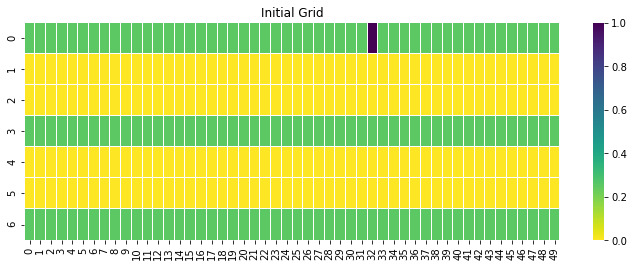

In [140]:
plt.figure(figsize=(12,4))
sns.heatmap(grid, cmap="viridis_r", linewidths=.005, vmin=0, vmax=1)
plt.title("Initial Grid")

## _A_
- t=1=constant
- change in direction is always $\frac{1}{4}$ probability left, $\frac{1}{4}$ right, $\frac{1}{2}$ forward

### static cars
Cars do appear on a lane or not - velocity is not considered. If the drunk is on a lane where a car appears, he's dead.

In [189]:
def model_step(grid, sideways=[0,3,6],
               t_constant=True,
               drunk_velocity=1, car_intensity=0.05, car_velocity=None,
               plot_progress=True):
    
    # get persons coordinates
    y,x = np.unravel_index(grid.argmax(), grid.shape)
    
    # roll persons movement
    direction = (0, 0)
    p_dir = np.random.uniform(0,1,1)
    if p_dir < 0.25:
        direction = (0, -1)
    elif 0.25 <= p_dir < 0.5:
        direction = (0, 1)
    elif 0.5 <= p_dir :
        direction = (1, 0)
    
    # make cars appear
    for lane in range(0, grid.shape[0]):
        if lane not in sideways:
            car_on_lane = (np.random.uniform(0,1,1) <0.05).item()
            if car_on_lane:
                grid[lane,] = 0.6
            if not car_on_lane:
                grid[lane,] = 0
    
    grid[y+direction[0], x+direction[1]] = 1.0
    grid[y, x] = grid[y, 0] # reset old coordinate 
    
    if plot_progress:
        plt.figure(figsize=(12,4))
        sns.heatmap(grid, cmap="viridis_r", linewidths=.005, vmin=0, vmax=1)
        plt.title("Initial Grid")
    return grid

In [201]:
grid, sideways = create_grid(street_lanes, street_length)

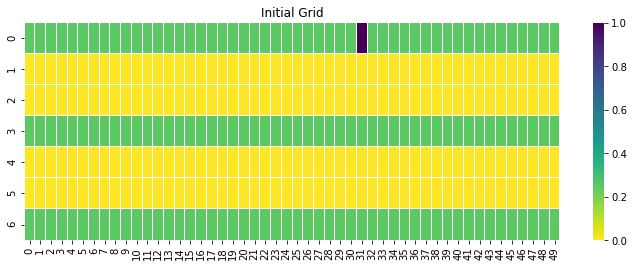

In [202]:
g = model_step(grid, sideways)


## _B_
- t=1=constant
- new direction = old direction +$\alpha$ with $\alpha$ is uniformly distributed in $[-2/3\pi; +2/3\pi]$

## C
-  t is exponentially distributed with intensity 1/time unit
- new direction = old direction +$\alpha$ with $\alpha$ is uniformly distributed in $[-2/3\pi; +2/3\pi]$